# Clustering Crypto

In [25]:
# Initial imports
import pandas as pd
import numpy as np
import hvplot.pandas
from path import Path
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


### Deliverable 1: Preprocessing the Data for PCA

In [2]:
# Load the crypto_data.csv dataset.
dataset = pd.read_csv('crypto_data.csv')
dataset.head()

,Unnamed: 0,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
0,42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
1,365,365Coin,X11,True,PoW/PoS,NaN,2300000000
2,404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
3,611,SixEleven,SHA-256,True,PoW,NaN,611000
4,808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


In [3]:
dataset['IsTrading'].nunique

<bound method IndexOpsMixin.nunique of 0        True
1        True
2        True
3        True
4        True
        ...  
1247     True
1248    False
1249    False
1250    False
1251    False
Name: IsTrading, Length: 1252, dtype: bool>

In [4]:
# Keep all the cryptocurrencies that are being traded.
not_trading = dataset[dataset['IsTrading']==False].index
dataset.drop(not_trading, inplace=True)

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1144 entries, 0 to 1247
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       1144 non-null   object 
 1   CoinName         1144 non-null   object 
 2   Algorithm        1144 non-null   object 
 3   IsTrading        1144 non-null   bool   
 4   ProofType        1144 non-null   object 
 5   TotalCoinsMined  685 non-null    float64
 6   TotalCoinSupply  1144 non-null   object 
dtypes: bool(1), float64(1), object(5)
memory usage: 63.7+ KB


In [5]:
dataset.shape

(1144, 7)

In [6]:
dataset.set_index('Unnamed: 0', inplace = True)

In [7]:
dataset.shape

(1144, 6)

In [8]:
dataset.index.rename('', inplace=True)

dataset.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
,,,,,,
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


In [9]:
# Keep all the cryptocurrencies that have a working algorithm.
for col in dataset.columns:
    print(f"Column {col} has {dataset[col].isnull().sum()} null values.")

Column CoinName has 0 null values.
Column Algorithm has 0 null values.
Column IsTrading has 0 null values.
Column ProofType has 0 null values.
Column TotalCoinsMined has 459 null values.
Column TotalCoinSupply has 0 null values.


In [10]:
# Remove the "IsTrading" column. 
dataset.drop(['IsTrading'], axis = 1, inplace = True)
dataset.shape

(1144, 5)

In [11]:
# Remove rows that have at least 1 null value.
dataset = dataset.dropna()
dataset.shape

(685, 5)

In [12]:
# Keep the rows where coins are mined.
not_mined = dataset[dataset['TotalCoinsMined']==0].index
dataset.drop(not_mined, inplace=True)

dataset.shape

(533, 5)

In [13]:
# Create a new DataFrame that holds only the cryptocurrencies names.
coinname = pd.DataFrame(dataset['CoinName'])
coinname


,CoinName
,
42,42 Coin
404,404Coin
1337,EliteCoin
BTC,Bitcoin
ETH,Ethereum
...,...
ZEPH,ZEPHYR
GAP,Gapcoin
BDX,Beldex


In [14]:
# Drop the 'CoinName' column since it's not going to be used on the clustering algorithm.
dataset = dataset.drop(['CoinName'], axis = 1)
dataset.head()

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
,,,,
42,Scrypt,PoW/PoS,4.199995e+01,42
404,Scrypt,PoW/PoS,1.055185e+09,532000000
1337,X13,PoW/PoS,2.927942e+10,314159265359
BTC,SHA-256,PoW,1.792718e+07,21000000
ETH,Ethash,PoW,1.076842e+08,0


In [16]:
# Use get_dummies() to create variables for text features.
X = pd.get_dummies(dataset, columns=["Algorithm", "ProofType"])
#ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0,1])], remainder='passthrough')
#X = np.array(ct.fit_transform(X))


In [17]:
X.shape

(533, 100)

In [18]:
# Standardize the data with StandardScaler().
X = StandardScaler().fit_transform(X)

X

array([[-0.11674788, -0.15286468, -0.0433555 , ..., -0.0433555 ,
        -0.0433555 , -0.0433555 ],
       [-0.09358885, -0.14499604, -0.0433555 , ..., -0.0433555 ,
        -0.0433555 , -0.0433555 ],
       [ 0.52587231,  4.4937636 , -0.0433555 , ..., -0.0433555 ,
        -0.0433555 , -0.0433555 ],
       ...,
       [-0.09523411, -0.13215444, -0.0433555 , ..., -0.0433555 ,
        -0.0433555 , -0.0433555 ],
       [-0.11658774, -0.15255408, -0.0433555 , ..., -0.0433555 ,
        -0.0433555 , -0.0433555 ],
       [-0.11674507, -0.15284989, -0.0433555 , ..., -0.0433555 ,
        -0.0433555 , -0.0433555 ]])

### Deliverable 2: Reducing Data Dimensions Using PCA

In [19]:
# Using PCA to reduce dimension to three principal components.
pca = PCA(n_components=3)

# Get two principal components for the iris data.
X = pca.fit_transform(X)

In [20]:
# Create a DataFrame with the three principal components.
df_X_pca = pd.DataFrame(
    data=X, columns=["principal component 1", "principal component 2", "principal component 3"]
)
df_X_pca.head()

,principal component 1,principal component 2,principal component 3
0,-0.345092,0.999971,-0.678484
1,-0.328397,1.000147,-0.678813
2,2.323883,1.620620,-0.599970
3,-0.137022,-1.319915,0.227496
4,-0.144071,-2.060805,0.481894


### Deliverable 3: Clustering Crytocurrencies Using K-Means

#### Finding the Best Value for `k` Using the Elbow Curve

C:\Users\manuu\anaconda3\envs\mlenv\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  f"KMeans is known to have a memory leak on Windows "


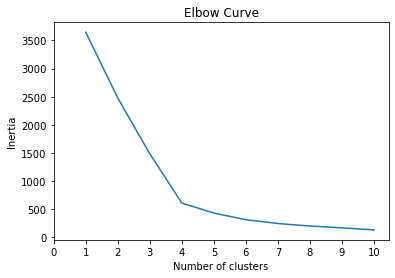

In [26]:
# Create an elbow curve to find the best value for K.
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(df_X_pca)
    inertia.append(km.inertia_)

# Creating the Elbow Curve
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

plt.plot(df_elbow['k'], df_elbow['inertia'])
plt.xticks(list(range(11)))
plt.title('Elbow Curve')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()


Running K-Means with `k=4`

In [27]:
# Initialize the K-Means model.

model = KMeans(n_clusters=4, random_state=0)

# Fit the model
model.fit(df_X_pca)

# Predict clusters
predictions = model.predict(df_X_pca)



In [31]:
# Create a new DataFrame including predicted clusters and cryptocurrencies features.
# Concatentate the crypto_df and pcs_df DataFrames on the same columns.

# Add the predicted class column to the dataframe
clustered_df = pd.DataFrame(data = dataset, index = dataset.index) 
clustered_df["PC 1"] = df_X_pca["principal component 1"]
clustered_df["PC 2"] = df_X_pca["principal component 2"]
clustered_df["PC 3"] = df_X_pca["principal component 3"]
#  Add a new column, "CoinName" to the clustered_df DataFrame that holds the names of the cryptocurrencies. 
clustered_df["CoinName"] = coins_name["CoinName"] 
#  Add a new column, "Class" to the clustered_df DataFrame that holds the predictions.
clustered_df["Class"] = model.labels_


# Print the shape of the clustered_df
print(clustered_df.shape)
clustered_df.head(10)

NameError: name 'coins_name' is not defined

### Deliverable 4: Visualizing Cryptocurrencies Results

#### 3D-Scatter with Clusters

In [ ]:
# Creating a 3D-Scatter with the PCA data and the clusters
# YOUR CODE HERE


In [ ]:
# Create a table with tradable cryptocurrencies.
# YOUR CODE HERE

In [ ]:
# Print the total number of tradable cryptocurrencies.
# YOUR CODE HERE

In [ ]:
# Scaling data to create the scatter plot with tradable cryptocurrencies.
# YOUR CODE HERE

In [ ]:
# Create a new DataFrame that has the scaled data with the clustered_df DataFrame index.
# YOUR CODE HERE

# Add the "CoinName" column from the clustered_df DataFrame to the new DataFrame.
# YOUR CODE HERE

# Add the "Class" column from the clustered_df DataFrame to the new DataFrame. 
# YOUR CODE HERE

plot_df.head(10)

In [ ]:
# Create a hvplot.scatter plot using x="TotalCoinsMined" and y="TotalCoinSupply".
# YOUR CODE HERE
